<a href="https://colab.research.google.com/github/eiririna/Neural-Style-Transfer/blob/main/style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
%matplotlib inline

In [3]:
import pprint 
from scipy import io
from matplotlib.pyplot import imshow

In [178]:
class CONFIG:                  #Class is like an object constructor
    IMAGE_WIDTH = 400
    IMAGE_HEIGHT = 300
    COLOR_CHANNELS = 3
    NOISE_RATIO = 0.2
    MEANS = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3)) 

In [128]:
import scipy.io
import imageio
import scipy.misc

In [129]:
def load_vgg_model(path):
    vgg = io.loadmat(path)
    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        wb = vgg_layers[0][layer][0][0][2]
        W = wb[0][0]
        b = wb[0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b
        return W, b
    def _relu(conv2d_layer):
        return tf.nn.relu(conv2d_layer)
    def _conv2d(prev_layer, layer, layer_name):
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(prev_layer, filters=W, strides=[1, 1, 1, 1], padding='SAME') + b
    def _conv2d_relu(prev_layer, layer, layer_name):
        return _relu(_conv2d(prev_layer, layer, layer_name))
    
    def _avgpool(prev_layer):
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    
    return graph

In [179]:
def generate_noise_image(content_image, noise_ratio=CONFIG.NOISE_RATIO):
    """
    Generates a noisy image by adding random noise to the content_image
    This will help content of "generated" image more rapidly match the content of "content" image
    """

    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20,
                                    (1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)).astype(
        'float32')

    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)

    return input_image

def reshape_image(image):
    # Reshape image to match expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))

    return image

def normalize_image(image):
    # Substract the mean to match the expected input of VGG16
    image = image - CONFIG.MEANS

    return image

def unnormalize_image(image):
    # Un-normalize the image so that it looks good
    image = image + CONFIG.MEANS

    return image

def reshape_and_normalize_image(image):
    """
    Reshape and normalize the input image (content or style)
    """
    image = reshape_image(image)
    image = normalize_image(image)

    return image

def save_image(path, image):
    image = unnormalize_image(image)

    # Clip and Save the image
    image = np.clip(image[0], 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [7]:
from google.colab import files

In [6]:
files.upload()

Saving imagenet-vgg-verydeep-19.mat to imagenet-vgg-verydeep-19.mat


In [131]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model('/content/sample_data/imagenet-vgg-verydeep-19.mat')
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

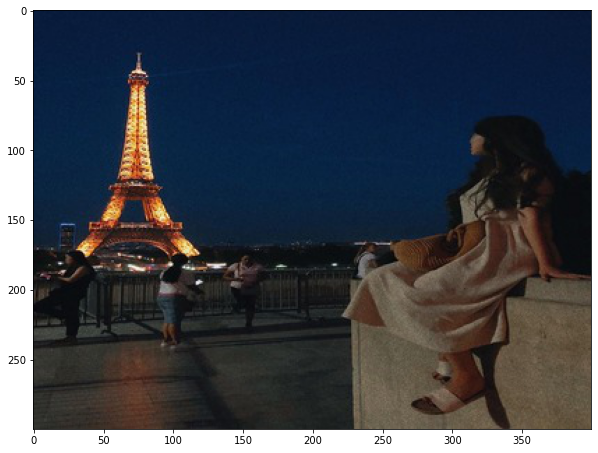

In [150]:
import imageio
content_image = imageio.imread('/content/nightparis.jpg')
plt.figure(figsize=(10,10))
plt.imshow(content_image);

In [133]:
content_image.shape

(300, 400, 3)

In [134]:
def compute_content_cost(a_C,a_G):
    #Retrieve dimensions from a_G
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    #Unrolled a_C and a_G
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    #Compute the Content Cost
    j_content = (1/(4*n_H*n_W*n_C))*(tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled))))

    return j_content

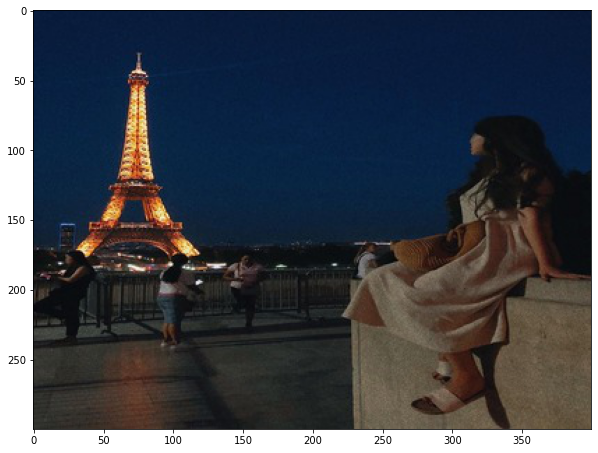

In [151]:
import imageio
content_image = imageio.imread('/content/nightparis.jpg')
plt.figure(figsize=(10,10))
plt.imshow(content_image);

(300, 400, 3)

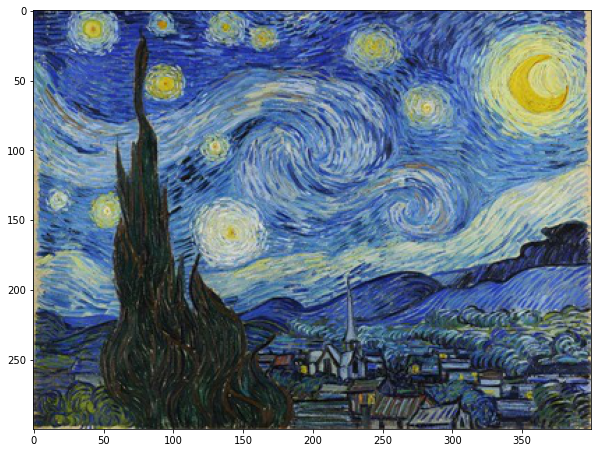

In [152]:
style_image = imageio.imread('/content/starnight.jpg')
plt.figure(figsize=(10,10))
plt.imshow(style_image)
style_image.shape

In [137]:
### Computing Cost for a single layer
def compute_style_cost_layer(a_S,a_G):
    #Retrieve dimensions from a_G
    m,n_H,n_W,n_C = a_G.get_shape().as_list()
    
    #unroll a_S and a_G
    a_S = tf.transpose(tf.reshape(a_S,shape=[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,shape=[n_H*n_W,n_C]))
    
    #Computing gram matrics
    S = tf.matmul(a_S,tf.transpose(a_S))
    G = tf.matmul(a_G,tf.transpose(a_G))
    
    #Compute the Style Cost
    j_style_layer = (1/(4*(n_C**2)*((n_H*n_W)**2)))*(tf.reduce_sum(tf.reduce_sum(tf.square(tf.subtract(S,G)))))
    
    return j_style_layer

In [138]:
style_layers = [('conv1_2',0.3),
               ('conv3_2',0.3),
               ('conv3_3',0.3),
               ('conv4_2',0.3),
               ('conv5_1',0.3)]

In [140]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [141]:
#compute total cost
#alpha and beta are the hypermeters that control the weights between content and style. 


def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    

    J = alpha * J_content + beta * J_style

    
    return J

In [142]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

import tensorflow.compat.v1 as f
sess = f.Session()
with sess as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [143]:
# Reset the graph
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

# Start interactive session
sess = tf.compat.v1.InteractiveSession()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [144]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()
#  Reshape and normalize the input image (content or style)
def reshape_and_normalize_image(image):
    image = np.reshape(image, ((1,) + image.shape))
    image = image - CONFIG.MEANS
    return image

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1771: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [154]:
content_image = imageio.imread('/content/nightparis.jpg')
content_image = reshape_and_normalize_image(content_image)


In [146]:
content_image.shape

(1, 300, 400, 3)

In [153]:
style_image = imageio.imread('/content/starnight.jpg')
style_image = reshape_and_normalize_image(style_image)

In [148]:
style_image.shape


(1, 300, 400, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


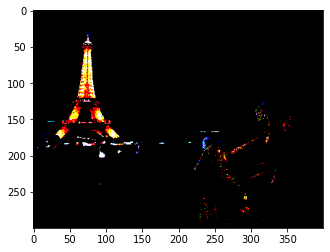

In [180]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);